# Classification

In [1]:
# %load ../helpers/header.py
# load ENV path to project from .profile 
import os, sys
PROJECT_ROOT_DIR=os.environ.get('ML_PATH')
sys.path.append(os.path.join(PROJECT_ROOT_DIR, "helpers")) # add helper modules to path

# MPL 
import MPL_header #load common MPL imports (from helpers)
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib widget 

# NP, constant seed, PD 
import numpy as np
np.random.seed(12345)
import pandas as pd

# Where to save the figures
SUB_DIR = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig", SUB_DIR)
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
print("70k digits, each 28x28=784 pixels", X.shape, y.shape, "each pixel goes from 0(White)-255(Black), e.g. X[12][323]=", X[12][323])

70k digits, each 28x28=784 pixels (70000, 784) (70000,) each pixel goes from 0(White)-255(Black), e.g. X[12][323]= 249.0


### Plot a digit

5 looks like this


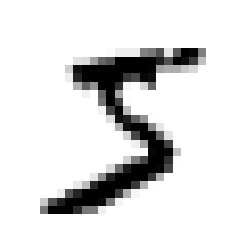

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary");
plt.axis("off");
print(y[0], "looks like this")

In [6]:
print("Object/string....,", y.dtype)
y = y.astype(np.uint8)
print("Casting to int....,", y.dtype)

Object/string...., object
Casting to int...., uint8


In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Already shuffled - good! Ensures: a) folds have equal split b) no repeatability in training. Shuffling is not good for e.g. time-series data (e.g. stcoks)

#  Binary Classifier: only try to say '5' or 'not 5'

In [8]:
# T/F 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=1234)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=1234)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96855, 0.95705, 0.96055])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
print("Accuracy is not the best metric for classifiers...(generally)")
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

Accuracy is not the best metric for classifiers...(generally)


array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict
#instead of scores, returns the actual predictions (clean, predictions are on the validation fold)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
# (true, pred)
confusion_matrix(y_train_5, y_train_pred)

array([[53427,  1152],
       [ 1125,  4296]])

### Row = actual class, column= predicted class
CM_00 = TN, CM_11 =TP, CM_10 = FN, CM_01 = FP

### Accuracy = $\frac{TP+TN}{TP+TN+FP+FN}$
Precision = $\frac{TP}{TP+FP}$  (<ins>**penalty for mis-firing (over-classifing)**</ins>, "how well did it trigger?"/percentage of your results which are relevant)

### Really, need a second metric (otherwise e.g. 1/1=100%, not constrained).
Recall (sensitivity or true positive rate (TPR)) = $\frac{\rm{TP}}{\rm{TP+FN}}$ (**<ins>penalty for "missed out cases"/ (how well did it trigger given truth) (under-classifiing)</ins>**/percentage of total relevant results correctly classified by your algorithm)

<img src="../docs/CM.png" width="600">

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4296 / (4296 + 1152)

0.788546255506608

In [17]:
recall_score(y_train_5, y_train_pred) # == 4296/ (4296+1125)

0.7924737133370227

#### Harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.
$$F_1 = \frac{2}{\frac{1}{\rm{precision}}+\frac{1}{\rm{recall}}}=2\times\frac{\rm{precision}\times\rm{recall}}{\rm{precision}+\rm{recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7905051062655257

### The F1 score favors classifiers that have similar precision and recall. This is not always what you want! (e.g. if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision))

In [19]:
y_scores = sgd_clf.decision_function([some_digit]); y_scores

array([2903.29040233])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold); y_some_digit_pred

array([ True])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
#return scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [23]:
# using scores -> prec/reacall for all THRs
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

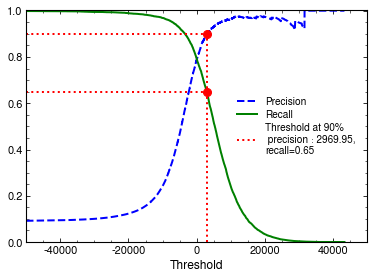

In [81]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlabel("Threshold")
    plt.axis([-50000, 50000, -0.001, 1.001])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:");
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:", label="Threshold at 90%\n precision: {:.2f}, \nrecall={:.2f}".format(threshold_90_precision, recall_90_precision))
plt.plot([threshold_90_precision], [0.9], "ro")                                            
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                            
plt.legend(loc="center right")
# from misc import save_fig
# save_fig("precision_recall_vs_threshold_plot")  

No handles with labels found to put in legend.


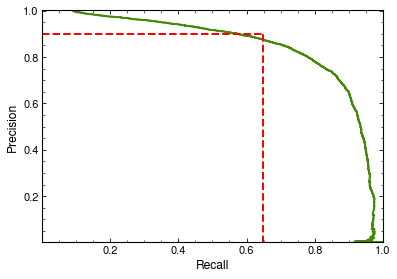

In [102]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(precisions[:-1], recalls[:-1])
    plt.legend()
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0.001, 1.001, 0.001, 1.001])

plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0.0, 0.9], "r--");
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r--");

In [103]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [104]:
precision_score(y_train_5, y_train_pred_90)

0.9000255689082076

In [105]:
recall_score(y_train_5, y_train_pred_90)

0.6493266924921601

### If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”

In [107]:
### ROC: TPR (recall) vs FPR (negative inc. classified as post) ( recall vs. 1- spec., where specificity=TNR)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

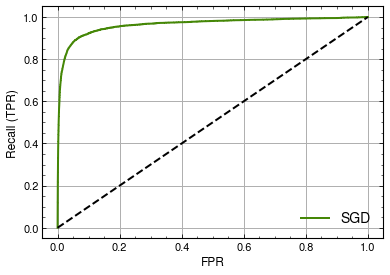

In [132]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel('FPR')
    plt.ylabel('Recall (TPR)')
    plt.grid(linewidth=1)
    plt.legend(fontsize=14)

plot_roc_curve(fpr, tpr, label="SGD") 
plt.show()

In [122]:
 # perfect AUC for ROC is 1
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores) 

0.9641674176567231

### Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top- left corner).

In [123]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=123)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [128]:
print("Binary prob class scores:")
y_probas_forest

Binary prob class scores:


array([[0.13, 0.87],
       [1.  , 0.  ],
       [0.98, 0.02],
       ...,
       [0.06, 0.94],
       [0.93, 0.07],
       [0.92, 0.08]])

In [130]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

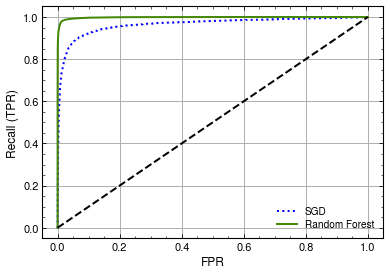

In [137]:
plt.plot(fpr, tpr, "b:", label="SGD") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [138]:
print("Random Forest performs better", roc_auc_score(y_train_5, y_scores_forest))

Random Forest performs better 0.9981934920206696


In [136]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
forest_ps= precision_score(y_train_5, y_train_pred_forest)
forest_rs = recall_score(y_train_5, y_train_pred_forest)
print("Random Forest: precision={0:.2f}, recall={1:.2f}".format(forest_ps, forest_rs))

Random Forest: precision=0.99, recall=0.87


# Multiclass Classification